In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import random

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:75]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [15]:
returns = returns_df['REEL'].values
test_returns = test_returns_df['REEL'].values

In [4]:
returns_mean = np.mean(returns)
returns_norm = returns - returns_mean

## Preprocessing

In [5]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)
    
    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k
    
    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)
        
        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise RuntimeError("Solution not found")
            
    return params

In [6]:
params = igmm(returns_norm)
processed_returns = W_delta((returns_norm - params[0]) / params[1], params[2])
returns_max = np.max(np.abs(processed_returns))
processed_returns /= returns_max

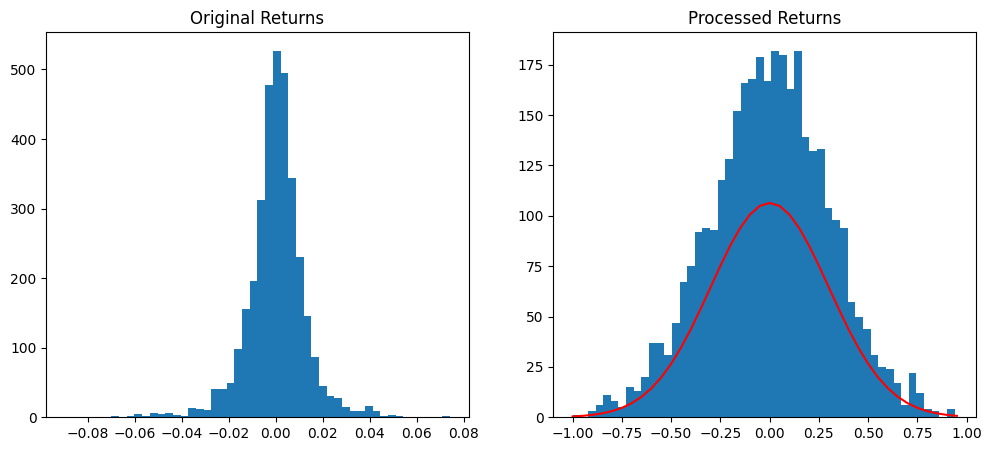

In [7]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(returns, bins=50)
plt.title('Original Returns')
plt.subplot(1,2,2)
plt.hist(processed_returns, bins=50)
x_axis = np.arange(-1, 1, 0.05)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.3) * 80, color='r')
plt.title('Processed Returns')
plt.show()

In [8]:
# Dataset class
class ReturnsDataset(Dataset):
    def __init__(self, data, window=252):
        self.data = data
        self.window = window
        
    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()
    
    def __len__(self):
        return len(self.data) - self.window

## Model Archtecture

In [9]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()
        
        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        
        self.init_weights()
        
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)
            
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res


class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        dilation = 1
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()
        
    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)


class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)
        
    def forward(self, x):
        return torch.tanh(self.net(x))


class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)
        
    def forward(self, x):
        return torch.sigmoid(self.net(x))


In [10]:
# Training parameters
clip_value = 0.01
lr = 0.0002
num_epochs = 50
nz = 3
batch_size = 30
seq_len = 252  # 252 trading days in a year

# Create models and optimizers
netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.RMSprop(netD.parameters(), lr=lr)
optG = optim.RMSprop(netG.parameters(), lr=lr)

# Create dataset and dataloader
dataset = ReturnsDataset(processed_returns, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
t = tqdm(range(num_epochs))
for epoch in t:
    for i, data in enumerate(dataloader, 0):
        # Train discriminator
        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()
        
        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()
        
        # Clip weights
        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
    
        # Train generator less frequently
        if i % 5 == 0:
            netG.zero_grad()
            noise = torch.randn(batch_size, seq_len, nz, device=device)
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()            
    
    # Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))
    
    # Checkpoint every 10 epochs
    if epoch % 10 == 0:
        torch.save(netG, f'returns_netG_epoch_{epoch}.pth')
        torch.save(netD, f'returns_netD_epoch_{epoch}.pth')


  0%|          | 0/50 [00:00<?, ?it/s]c:\Users\nicka\master-thesis\packages\Lib\site-packages\torch\nn\modules\conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv1d(
Loss_D: 0.00010493 Loss_G: -0.49187070: 100%|██████████| 50/50 [18:05<00:00, 21.72s/it] 


In [11]:
# Generate samples and visualize
def generate_paths(n=5, path_length=252, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, path_length, nz, device=device)
        fake = netG(noise).detach().cpu().reshape(path_length).numpy()
        return_path = inverse(fake * returns_max, params) + returns_mean
        fakes.append(return_path)
    
    if n > 1:
        df = pd.DataFrame(fakes).T
        return df.cumsum() if cumsum else df
    else:
        path = fakes[0]
        return np.cumsum(path) if cumsum else path

Text(0.5, 1.0, '5 Generated Return Paths (252 trading days)')

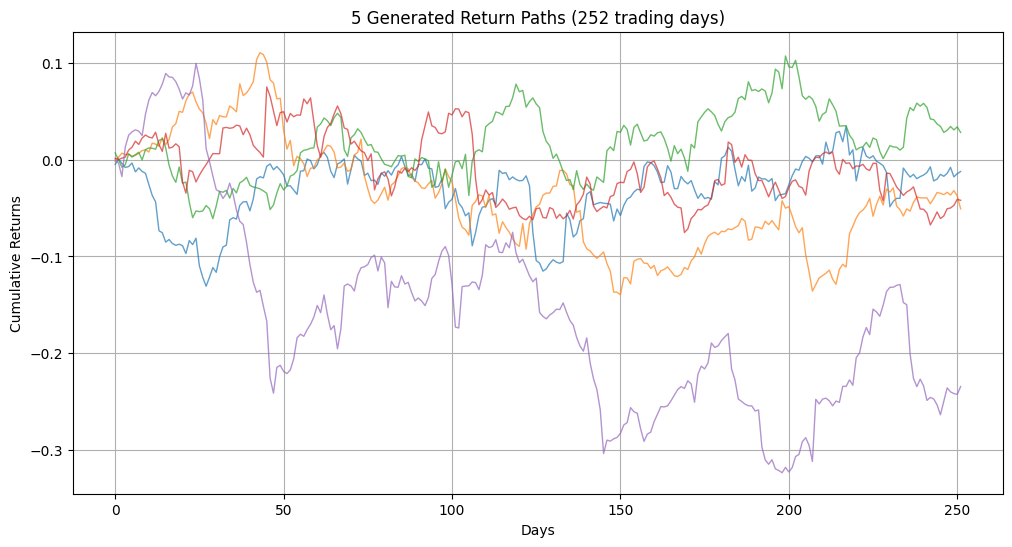

In [12]:
# Generate and plot 5 cumulative return paths
fake_paths = generate_paths(5)
plt.figure(figsize=(12,6))
plt.plot(fake_paths, linewidth=1, alpha=0.7)
plt.grid(True)
plt.xlabel('Days')
plt.ylabel('Cumulative Returns')
plt.title('5 Generated Return Paths (252 trading days)')


In [17]:
def generate_fakes(n=1, seq_length=252, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, seq_length, nz, device=device)
        fake = netG(noise).detach().cpu().reshape(seq_length).numpy()
        fake_returns = inverse(fake * returns_max, params) + returns_mean
        fakes.append(fake_returns)
    
    if n > 1:
        if not cumsum:
            return pd.DataFrame(fakes).T
        fakes_df = pd.DataFrame(fakes).T.cumsum()
        return fakes_df
    elif not cumsum:
        return fake_returns
    return np.cumsum(fake_returns)

<Figure size 1200x600 with 0 Axes>

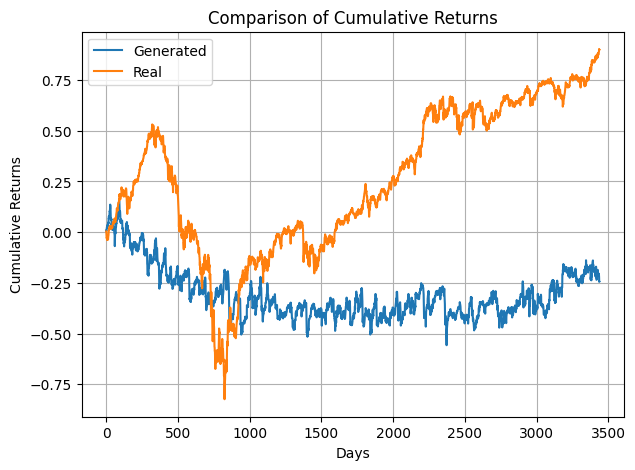

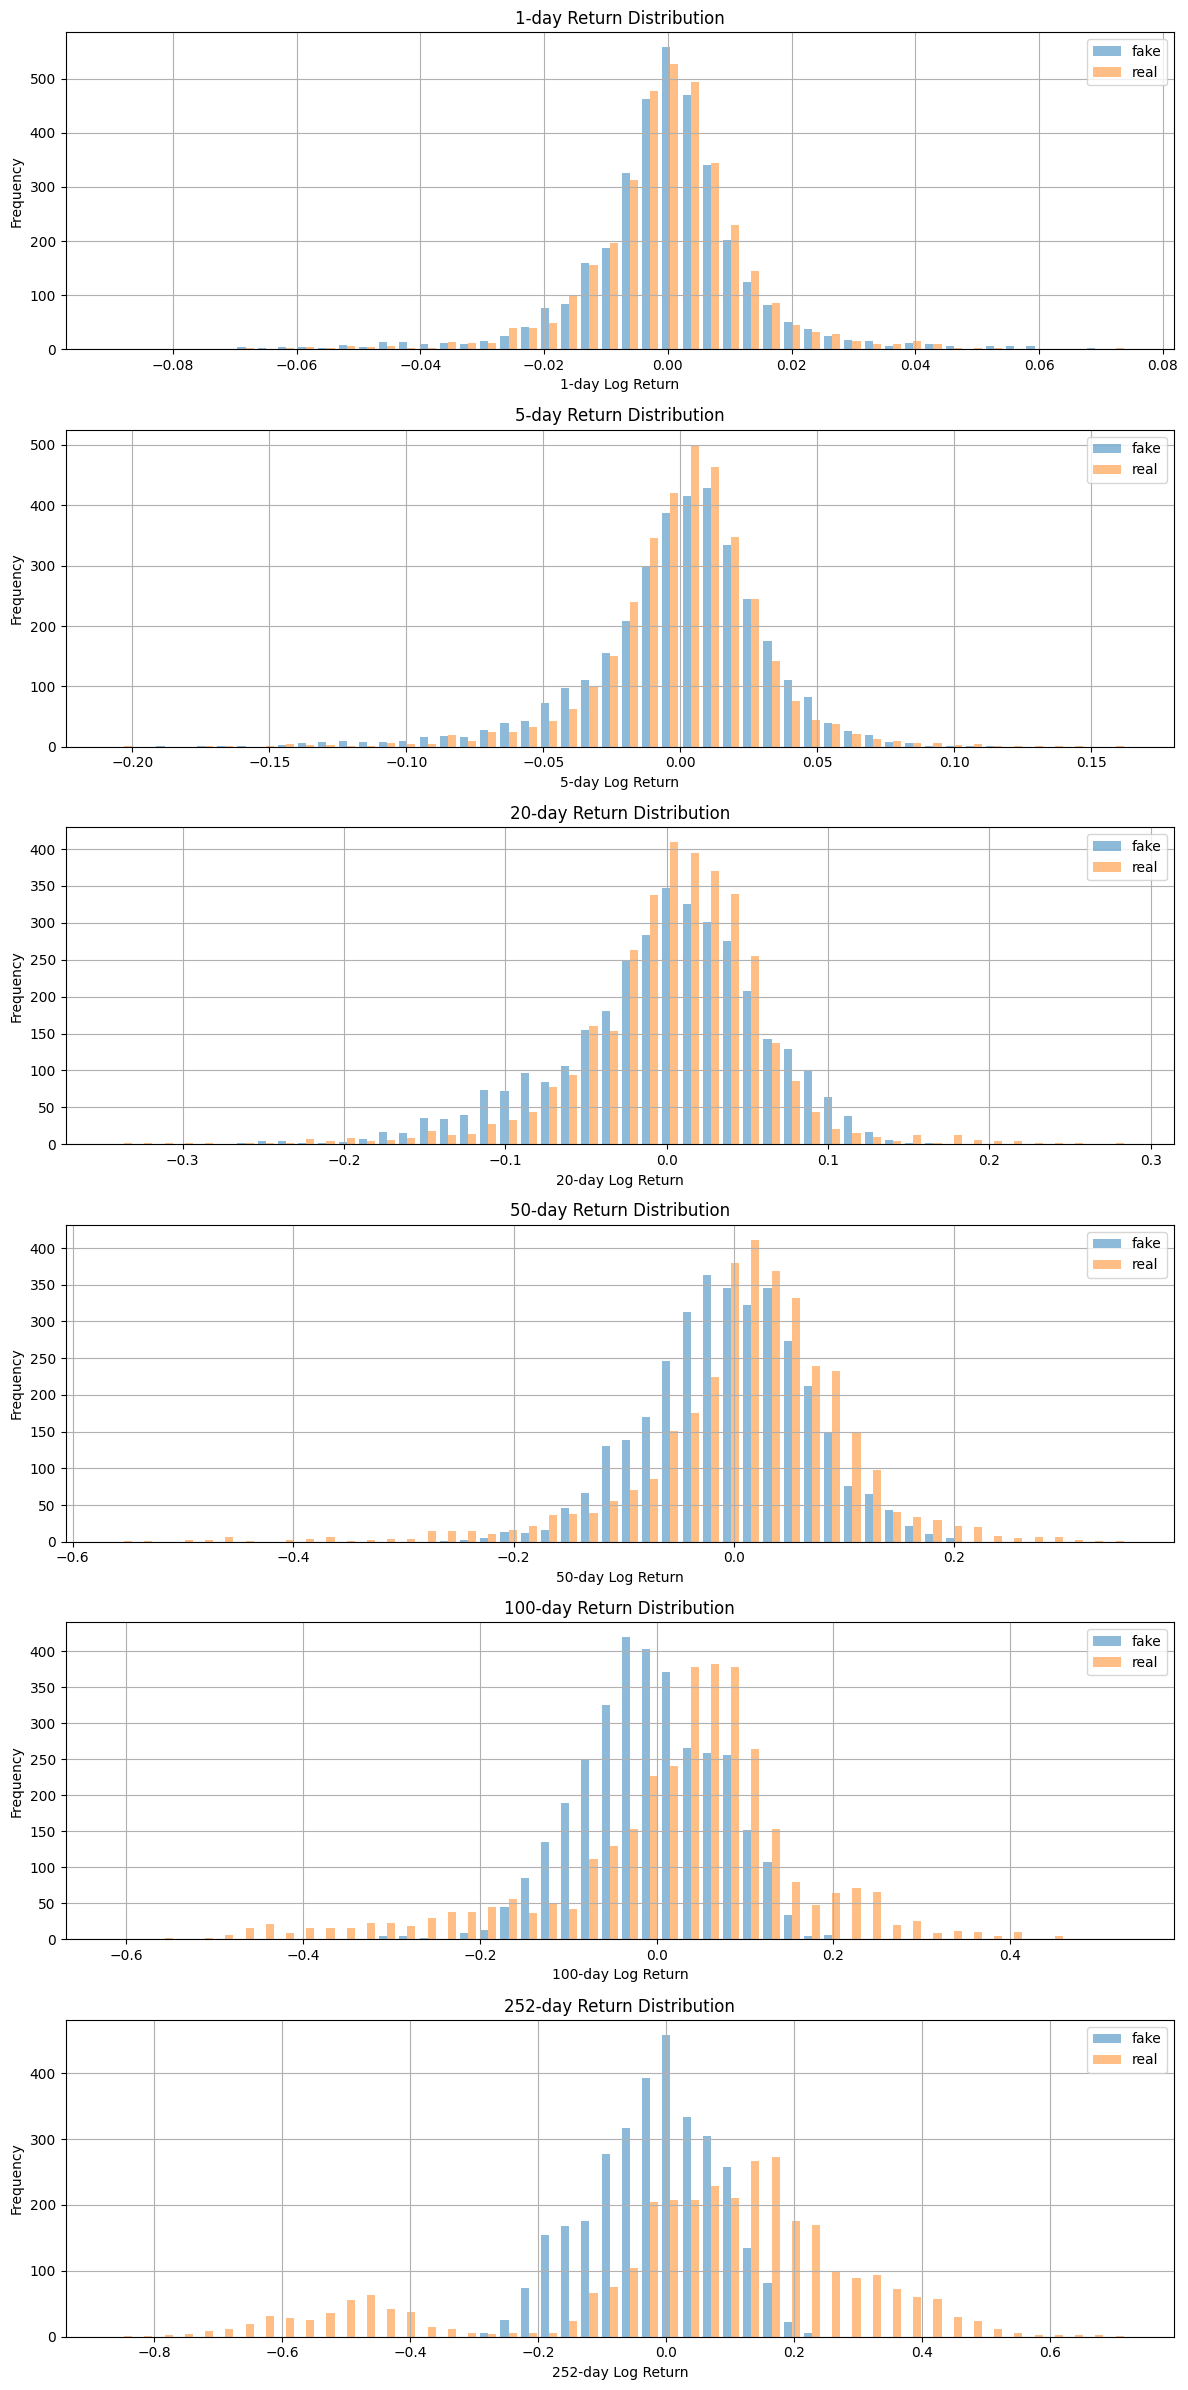

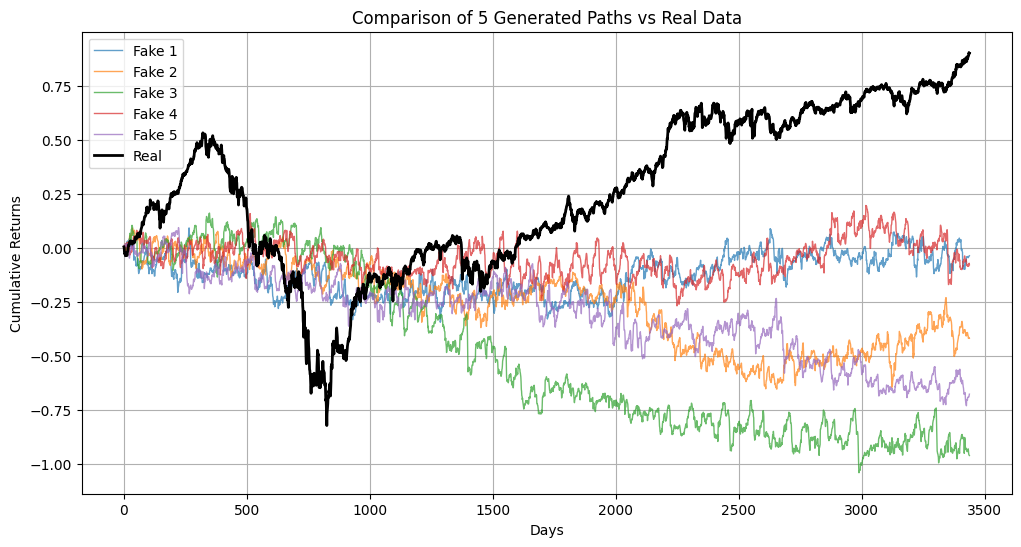

In [20]:
def compare_distributions(test_returns, horizons=[1, 5, 20, 50, 100]):
    # Create real cumulative returns
    real_cum = np.cumsum(test_returns)
    
    # Generate a fake path with same length as real data
    fake_cum = generate_fakes(seq_length=len(test_returns))
    
    # Create a dataframe with both series
    comp_df = pd.DataFrame({
        'fake': fake_cum,
        'real': real_cum
    })
    
    # Plot cumulative returns comparison
    plt.figure(figsize=(12, 6))
    comp_df.plot()
    plt.grid(True)
    plt.title('Comparison of Cumulative Returns')
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.legend(['Generated', 'Real'])
    plt.show()
    
    # Plot return distributions at different horizons
    fig, axes = plt.subplots(len(horizons), 1, figsize=(12, 4*len(horizons)))
    
    for i, horizon in enumerate(horizons):
        if len(horizons) == 1:
            ax = axes
        else:
            ax = axes[i]
            
        # Calculate returns over the specified horizon
        fake_returns = comp_df['fake'].diff(horizon).dropna()
        real_returns = comp_df['real'].diff(horizon).dropna()
        
        # Plot histograms
        ax.hist([fake_returns, real_returns], bins=50, alpha=0.5, label=['fake', 'real'])
        ax.legend(loc='upper right')
        ax.set_xlabel(f'{horizon}-day Log Return')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{horizon}-day Return Distribution')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Generate multiple fake paths for comparison
    n_paths = 5
    fake_paths = generate_fakes(n=n_paths, seq_length=len(test_returns))
    
    plt.figure(figsize=(12, 6))
    for i in range(n_paths):
        plt.plot(fake_paths[i], linewidth=1, alpha=0.7, label=f'Fake {i+1}')
    plt.plot(real_cum, linewidth=2, color='black', label='Real')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Cumulative Returns')
    plt.title(f'Comparison of {n_paths} Generated Paths vs Real Data')
    plt.show()
    
    return comp_df

# Run the comparison with test data
comp_df = compare_distributions(returns, horizons=[1, 5, 20, 50, 100, 252])